# Capstone Project - The Battle of Neighborhoods 

## 1. Introduction of the business problem

For opening a new restaurant, there are some key factors determine whether the business is finally successful or not. How to get some advanced advice for an investor who is planning to open a new restaurant will be expected strongly. The inventor want to know the success indicator if he/she is planning to open a restaurant in a certain venue and compare the indicator score among different venue, then a better address can be found out for their final success. Hence a predication system  will be very helpful to help restaurant investors to avoid the risk of investment because the wrong venue selection. 

## 2. Data explaration 

To train the model, you will see how we step by step explore Foursquare data to construct pertinent information as reasonable feature dataset.

### 2.1 Explore the New York neighborhood location data

To get location data, first we believe a good restaurant must own plenty of client source, i.e it can't be too far from Neighborhood where people clustered. So we uploaded total of 5 boroughs and 306 neighborhoods. In order to segment the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and longitude coordinates of each neighborhood.

In [1]:
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab

import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
#import folium # map rendering library

from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough']
    neighborhood_name = data['properties']['name']

    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]

    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.shape    

(306, 4)

In [4]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [5]:
#Display the first 5 rows
neighborhoods.head(5)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### 2.2 Explore the New York restaurants data
Now that we have all the neighborhoods listed, next step we will start from here, to get all the restaurants from New York as training data. These restaurants are representative, because they are close to resident people, in other words, they are close to potential clients.

In [7]:
column_names = ['v_id', 'v_name', 'v_dist', 'v_cat']
df1 = pd.DataFrame(columns=column_names)
df1.set_index('v_id')
df1.index.name = 'v_id'

df1 will be used to host the coming restaurant data. Through Foursquare *"search"* API we will first get all nearby restaurants for each of the above neighborhoods, to construct a full data list of all restaurant sit near those 306 New York neighborhoods.

In [8]:
CLIENT_ID = 'DXIROGA5WKZI34UAZJSKZNWIEHM4CNB4YXGSVE4MACY2X0Q4' # your Foursquare ID
CLIENT_SECRET = 'DYY3YOXVHCG1F1XYODE0EQF2NOSX2DEVJV3MTYVFWO5M4UA3' # your Foursquare Secret
VERSION = '20190626' # Foursquare API version
LIMIT = 1000 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

for i in range(len(neighborhoods)):
    neighborhood_latitude   = neighborhoods.loc[i,"Latitude"]
    neighborhood_longitude  = neighborhoods.loc[i,"Longitude"]
    neighborhood_name       = neighborhoods.loc[i,"Neighborhood"]
    neighborhood_borough    = neighborhoods.loc[i,"Borough"]
    url = 'https://api.foursquare.com/v2/venues/search?&query=Restaurant,Coffee&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION,neighborhood_latitude,neighborhood_longitude,radius,LIMIT)
    results = requests.get(url).json()
    with open("rstlist_{}.json".format(i), "w") as f:
        json.dump(results, f)

    with open("rstlist_{}.json".format(i),'r') as load_f:
        results = json.load(load_f)
# transform the ID list json dict into a DF
    for v in results['response']['venues']:
        v_id=v.get("id")
        v_name=v.get("name")
        v_dist=v.get("location")["distance"]
        v_cat=None
        if not(v.get("categories")):continue
        for ca in v.get("categories"):
            if ca.get("primary"):v_cat=ca.get("name")
        try:
            df1=df1.append({'v_id': v_id,
                        'v_name': v_name,
                        'v_dist': v_dist,
                        'v_cat':v_cat
                       },
                      ignore_index=True)
        except:pass
    df1.to_csv('rest.csv')

In [9]:
  df1.shape

(9395, 4)

In [10]:
df1.head(5)

,v_id,v_name,v_dist,v_cat
0,4db03c875da32cf2df4509f4,Big Daddy's Caribbean Taste Restaurant,1008,Caribbean Restaurant
1,508af256e4b0578944c87392,Cooler Runnings Jamaican Restaurant Inc,479,Caribbean Restaurant
2,4c994113a004a1cdc3393e6e,Bay 241 Restaurant & Lounge,792,Caribbean Restaurant
3,4c66e0068e9120a15929d964,Kaieteur Restaurant & Bakery,1011,Caribbean Restaurant
4,4d375ce799fe8eec99fd2355,Ripe Kitchen & Bar,798,Caribbean Restaurant


We have stored the basic restaurant information into a csv file as local file, the listed information include:
* v_id: the venue id of the restaurant, we will then use this ID to approach more data around the restaurant
* v_name: the name of the restaurant
* v_dist: the distance from  restaurant to related neighborhood
* v_cat: the restaurant's major category

Remember each restaurant may be close to multiple neighborhoods, we need to merge them.  The next step we will add more advanced data to extend the restaurant data with more features and meanwhile remove duplication.

a reminder here: the dumped csv file above embedded some encoding bugs which cause Python decode exception error, so a special data washing is done to clean those dirty data( here manually). We then change the csv file name to "ny_restaurant", hence after we will use this clean data file. 

### 2.3 Explore advanced restaurants data to construct full feature 


__First, we come up with two new numerical features:__ 
* The average distance from one restaurant to all its nearby neighborhoods, 
* How many neighborhoods sit around a certain restaurant

In [11]:
# The code was removed by Watson Studio for sharing.

(5290, 5)

In [12]:
df2.head(2)

,v_name,v_cat,avg_dist_2_neighborhood,cnt_near_neighborhood,restaurant_id
0,Cooler Runnings Jamaican Restaurant Inc,Caribbean Restaurant,479.0,1,508af256e4b0578944c87392
1,McDonald's,Fast Food Restaurant,904.0,1,4be5f0eacf200f47d1fa133c


Form above data, you can see two new columns named __"avg_dist_2_neighborhood"__, and __"cnt_near_neighborhood"__. The useless column "v_dist" has been dropped off, and duplicated restaurants are also grouped in a single line in the dataframe. 

Then, more features will be added as following: 
* Latitude of the restaurant
* Longitude of the restaurant
* Average rating of clustered restaurants where this restaurant is the centroid
* How many recommended popular venues nearby this restaurant 
* The label(or the true target of regression) of the restaurant
* The menu items(food) offered from this restaurant

In order to get the basic restaurant information, the following foursquare API need to be invoked. But because I only have the free developer access to foursquare, and there is limitation for  API invoke  times  and  data  download  amount,  so it  take  days  to save  daily API to store  the  data. So  I elimited code here and store  the csv and then load it back for  coding. 
https://api.foursquare.com/v2/venues/{ restaurant id }   
https://api.foursquare.com/v2/venues/explore/ll{restaurant Latitude, Longitude}   
https://api.foursquare.com/v2/venues/{ recommend venue id }    
https://api.foursquare.com/v2/venues/{restaurant id}/menu   


In [80]:
# here we load part of the data as sample to have a look
body = client_ce4029ba54864f23a14fccc18bba1bf1.get_object(Bucket='machinelearningwithpythonproject-donotdelete-pr-hk8mf9cqyk6jzv',Key='restaurant_data copy 1.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
df2 = pd.read_csv(body)
df2.dropna(subset=["rating"],inplace=True)# remove dirty data withpoupt label    
df2["avg_rate"]=df2["rating"].astype(float)+np.random.uniform(-2,2,size=len(df2)) #have no premuim access,have to make this
df2.head()
df2.to_csv("nv_restaurant_data.csv")

In [81]:
df2.dtypes

v_name                      object
v_cat                       object
avg_dist_2_neighborhood    float64
cnt_near_neighborhood        int64
restaurant_id               object
lat                        float64
lng                        float64
avg_rate                   float64
nearby_rec                 float64
rating                     float64
menu                        object
dtype: object

In [82]:
#df2["rating"]=df2["rating"].astype(float)
df2.shape

(122, 11)

In [83]:
df2.head()

,v_name,v_cat,avg_dist_2_neighborhood,cnt_near_neighborhood,restaurant_id,lat,lng,avg_rate,nearby_rec,rating,menu
0,Cooler Runnings Jamaican Restaurant Inc,Caribbean Restaurant,479.0,1,508af256e4b0578944c87392,40.898276,-73.850381,6.462058,10.0,6.5,NaN
1,McDonald's,Fast Food Restaurant,904.0,1,4be5f0eacf200f47d1fa133c,40.902645,-73.849485,7.180005,10.0,6.5,Big Mac®|Cheeseburger|Double Cheeseburger|Hamb...
2,Bay 241 Restaurant & Lounge,Caribbean Restaurant,792.0,1,4c994113a004a1cdc3393e6e,40.901823,-73.847089,7.997693,10.0,6.5,NaN
3,New Happy Joy,Chinese Restaurant,1041.0,1,4ce164f194c3b60c246f76ea,40.903797,-73.850105,7.605170,10.0,6.5,Spring Roll|Fantail Shrimp|Pork Egg Roll (1)|...
4,Cool Running Restaurant,Food,396.0,1,4f32aa4719836c91c7edd32c,40.898130,-73.848516,6.472761,6.0,6.6,NaN


Define a dictionary as below:

|Attribute Name|Data description |Data Type|Potential Contribution|
|:-|-|-|-|
|v_name|Restaurant name|String|n/a|
|v_cat|Category|Foursquare Category|certain Category maybe special popular, more easily catch eyes 
|avg_dist_2_neighborhood|Average distance from this restaurant  to all its nearby neighborhoods|float|the lower means distance closer to potential clients|
|cnt_near_neighborhood|how many nearby neighborhoods are close to this restaurant , for example with 1 km|int|the more means more potential clients |
|restaurant_id|Venue ID |Foursquare ID |n/a
|lat|latitude|float|n/a|
|lng|longitude|float|n/a|
|avg_rate|Average rating  of nearby popular sites(such as food, drinks, coffee, shops, arts, outdoors,etc.) |float|the higher, the more possibility for stable client source|
|nearby_rec|the total number of popular sites recommended from Foursquare which centriod by the restaurant |int|the higher, the more possibility for stable client source|
|menu|special food offered|list of food items|will do text clustering first before used for classification model|
|rating|the restaurant rating( how good the restaurant is)|float/classification|the label or target value(y)|


Notice: additional action needed for the the *"menu"* attribute as can't use it in classification model directly. I need to vectorize it and cluster the menus to categorize them. This part will be introduced in the *Text Clustering* model in the next segment.

## 3. Methdologies

### 3.1 Model Selection

I make the model to give a prediction as simply “bad or good” classification by turning "rating" to binary classification. In that way, I need to label restaurant data set by rule: take the 75% value 7.75 as a threshold, if rating larger than 7.75, then label it as “Good”(1); or else label it as “not good”(0).

In [84]:
df2["label"] = df2["rating"].apply(lambda x: "1" if x>=7.75 else "0")

In [85]:
df2.head()

,v_name,v_cat,avg_dist_2_neighborhood,cnt_near_neighborhood,restaurant_id,lat,lng,avg_rate,nearby_rec,rating,menu,label
0,Cooler Runnings Jamaican Restaurant Inc,Caribbean Restaurant,479.0,1,508af256e4b0578944c87392,40.898276,-73.850381,6.462058,10.0,6.5,NaN,0
1,McDonald's,Fast Food Restaurant,904.0,1,4be5f0eacf200f47d1fa133c,40.902645,-73.849485,7.180005,10.0,6.5,Big Mac®|Cheeseburger|Double Cheeseburger|Hamb...,0
2,Bay 241 Restaurant & Lounge,Caribbean Restaurant,792.0,1,4c994113a004a1cdc3393e6e,40.901823,-73.847089,7.997693,10.0,6.5,NaN,0
3,New Happy Joy,Chinese Restaurant,1041.0,1,4ce164f194c3b60c246f76ea,40.903797,-73.850105,7.605170,10.0,6.5,Spring Roll|Fantail Shrimp|Pork Egg Roll (1)|...,0
4,Cool Running Restaurant,Food,396.0,1,4f32aa4719836c91c7edd32c,40.898130,-73.848516,6.472761,6.0,6.6,NaN,0


In [86]:
df2[["v_name","rating","label"]].head()

,v_name,rating,label
0,Cooler Runnings Jamaican Restaurant Inc,6.5,0
1,McDonald's,6.5,0
2,Bay 241 Restaurant & Lounge,6.5,0
3,New Happy Joy,6.5,0
4,Cool Running Restaurant,6.6,0


### 3.2 Handeling dummy variables 

The last step is to working on the dummy variable(menu group and category). For menu feature, I won't consider the influence for a while, so I will drop menu and will use the panda's method 'get_dummies' to assign numerical values to category.

In [87]:
df2.drop("menu",axis=1,inplace=True) 

In [88]:
df2.head()

,v_name,v_cat,avg_dist_2_neighborhood,cnt_near_neighborhood,restaurant_id,lat,lng,avg_rate,nearby_rec,rating,label
0,Cooler Runnings Jamaican Restaurant Inc,Caribbean Restaurant,479.0,1,508af256e4b0578944c87392,40.898276,-73.850381,6.462058,10.0,6.5,0
1,McDonald's,Fast Food Restaurant,904.0,1,4be5f0eacf200f47d1fa133c,40.902645,-73.849485,7.180005,10.0,6.5,0
2,Bay 241 Restaurant & Lounge,Caribbean Restaurant,792.0,1,4c994113a004a1cdc3393e6e,40.901823,-73.847089,7.997693,10.0,6.5,0
3,New Happy Joy,Chinese Restaurant,1041.0,1,4ce164f194c3b60c246f76ea,40.903797,-73.850105,7.605170,10.0,6.5,0
4,Cool Running Restaurant,Food,396.0,1,4f32aa4719836c91c7edd32c,40.898130,-73.848516,6.472761,6.0,6.6,0


In [89]:
df2=df2[["v_cat","avg_dist_2_neighborhood","cnt_near_neighborhood","avg_rate","label"]]

In [90]:
dummy_variable_1 = pd.get_dummies(df2["v_cat"])

In [91]:
df = pd.concat([df2, dummy_variable_1], axis=1)
df.drop("v_cat", axis = 1, inplace=True)

In [92]:
df.head()

,avg_dist_2_neighborhood,cnt_near_neighborhood,avg_rate,label,American Restaurant,Asian Restaurant,Bakery,Bar,Caribbean Restaurant,Chinese Restaurant,Coffee Shop,Diner,Fast Food Restaurant,Food,Food Truck,Halal Restaurant,Indian Restaurant,Irish Pub,Italian Restaurant,Kitchen Supply Store,Latin American Restaurant,Mexican Restaurant,Music Venue,Other Nightlife,Pizza Place,Pub,Restaurant,Salvadoran Restaurant,Sandwich Place,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Tanning Salon
0,479.0,1,6.462058,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,904.0,1,7.180005,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,792.0,1,7.997693,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1041.0,1,7.605170,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,396.0,1,6.472761,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 3.3 Classification model

The classification models was much more straightforward, with the location and food input features, I need to predict whether these choices , combine together, will bring up one success(1) or failed(0) business.
Here I have all the data for model training, I will divide them into training set and validation set:

In [93]:
y=  np.asarray(df["label"].astype("int"))
X=  np.asarray(df.drop("label", axis=1))

In [94]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (97, 32) (97,)
Test set: (25, 32) (25,)


In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


In [96]:
LR = LogisticRegression(C=0.1, solver='liblinear',class_weight={1:0.65,0:0.35}).fit(X_train,y_train)
LR

LogisticRegression(C=0.1, class_weight={0: 0.35, 1: 0.65}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [97]:
yhat = LR.predict(X_test)
yhat

array([0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0])

Lets try jaccard index for accuracy evaluation

In [98]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.83999999999999997

### 3.4 Evaluation

Now , from a comprehensive angle, look at accuracy of classifier through confusion matrix.

In [99]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[ 2  1]
 [ 3 19]]


In [100]:
# Compute confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

Confusion matrix, without normalization
[[ 2  1]
 [ 3 19]]


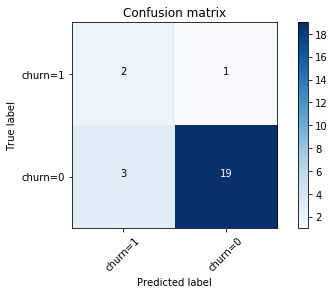

In [101]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')